# Using weather data to model wildfires in Quebec

## Preamble

At this point the data has largely been cleaned and assembled.  In this book we will put the finishing touches on the data set, perform a brief secondary EDA with the final data set, build models using the data set, and draw conclusions based on the models and how they performed.

In [ ]:
# importing necessary packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

<a id="toc"></a>
# Table of Contents

## [Data Preparation](#data_prep)

## [Exploratory Analysis](#eda)

## [Modeling](#modeling)
-   ### [Decision Tree](#decision_tree)
-   ### [Random Forest](#random_forest)
-   ### [Gradient Boosting](#gradient_boosting)
-   ### [Logistic Regression](#log_regression)
-   ### [K-Nearest Neigbours](#knn)
-   ### [Support Vector Machine](#svm)
-   ### [Naive Bayes](#nb)

## [Conclusions](#conclusions)
-   ### [Feature Importance](#feature_importance)
-   ### [Data Limitations](#data_limitations)

________________

_____________

<a id="data_prep"></a>
# Data Preparation

[[ go back to the top ]](#toc)

The bulk of the work to prepare the weather and wild fire data has already been done.  The fire data set was combined with the aggregate weather data, and appropriate classes have been assigned.  There are currently two data sets, one containing the weather data associated to no fire (class 0) and one containing the weather data associated to fire (class 1).  There are columns that have been carried along through the process that need to be removed (because they do not contain relevant weather data), and the two data sets need to be combined into one master data set.

In [ ]:
# import the two fire data sets
fire_df_0_raw = pd.read_csv('fire_0_df_v4.csv')
fire_df_1_raw = pd.read_csv('fire_1_df_v3.csv')

# a quick check of the fire data frames
display(fire_df_0_raw.info(), fire_df_1_raw.info(), fire_df_0_raw.head(), fire_df_1_raw.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           271 non-null    int64  
 1   FID                  271 non-null    int64  
 2   SRC_AGENCY           271 non-null    object 
 3   LATITUDE             271 non-null    float64
 4   LONGITUDE            271 non-null    float64
 5   REP_DATE             271 non-null    object 
 6   SIZE_HA              271 non-null    float64
 7   CAUSE                271 non-null    object 
 8   PROTZONE             271 non-null    object 
 9   ECOZ_NAME            271 non-null    object 
 10  FireLocation         271 non-null    object 
 11  WeatherLocation      271 non-null    object 
 12  x                    271 non-null    float64
 13  y                    271 non-null    float64
 14  MAX_REL_HUMIDITY     271 non-null    float64
 15  LOCAL_DAY            271 non-null    flo

None

None

,Unnamed: 0,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,...,STATION_NAME,SPEED_MAX_GUST,TOTAL_PRECIPITATION,CLIMATE_IDENTIFIER,MAX_TEMPERATURE,LOCAL_YEAR,TOTAL_SNOW,MIN_TEMPERATURE,SNOW_ON_GROUND,Class
0,0,328420,QC,52.5747,-76.5213,2019-06-01,0.0,L,nordique,Hudson Plain,...,LA GRANDE RIVIERE A,43.300000,0.0,7093716,14.3,2019.0,0.0,-4.1,0.0,0
1,1,328421,QC,52.5730,-76.5418,2019-06-01,0.0,L,nordique,Hudson Plain,...,LA GRANDE RIVIERE A,43.300000,0.0,7093716,14.3,2019.0,0.0,-4.1,0.0,0
2,2,328451,QC,49.1275,-65.2352,2019-06-28,0.0,L,intensive,Atlantic Maritime,...,CAP-MADELEINE,49.500000,0.0,7051163,14.3,2019.0,0.0,-4.1,0.0,0
3,3,328573,QC,48.7306,-64.9126,2019-06-28,0.0,L,intensive,Atlantic Maritime,...,GASPE A,44.416667,4.3,7052601,14.3,2019.0,0.0,-4.1,0.0,0
4,4,328876,QC,53.0048,-77.4008,2019-06-01,0.0,L,nordique,Taiga Shield East,...,LA GRANDE RIVIERE A,43.300000,0.0,7093716,14.3,2019.0,0.0,-4.1,0.0,0


,Unnamed: 0,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME,...,STATION_NAME,SPEED_MAX_GUST,TOTAL_PRECIPITATION,CLIMATE_IDENTIFIER,MAX_TEMPERATURE,LOCAL_YEAR,TOTAL_SNOW,MIN_TEMPERATURE,SNOW_ON_GROUND,Class
0,0,328420,QC,52.5747,-76.5213,2019-07-01,408.5,L,nordique,Hudson Plain,...,LA GRANDE RIVIERE A,39.0,26.1,7093716,27.5,2019.0,0.0,-2.2,0.0,1.0
1,1,328421,QC,52.5730,-76.5418,2019-07-01,34.5,L,nordique,Hudson Plain,...,LA GRANDE RIVIERE A,39.0,26.1,7093716,27.5,2019.0,0.0,-2.2,0.0,1.0
2,2,328451,QC,49.1275,-65.2352,2019-07-28,0.0,L,intensive,Atlantic Maritime,...,CAP-MADELEINE,46.0,26.1,7051163,27.5,2019.0,0.0,-3.1,0.0,1.0
3,3,328573,QC,48.7306,-64.9126,2019-07-28,0.3,L,intensive,Atlantic Maritime,...,GASPE A,46.0,26.1,7052601,27.5,2019.0,0.0,-2.2,0.0,1.0
4,4,328876,QC,53.0048,-77.4008,2019-07-01,25.5,L,nordique,Taiga Shield East,...,LA GRANDE RIVIERE A,39.0,26.1,7093716,27.5,2019.0,0.0,-2.2,0.0,1.0


In [ ]:
# getting the columns names in preparation to remove unnecessary columns

print(fire_df_0_raw.columns)

print(fire_df_1_raw.columns)

Index(['Unnamed: 0', 'FID', 'SRC_AGENCY', 'LATITUDE', 'LONGITUDE', 'REP_DATE',
       'SIZE_HA', 'CAUSE', 'PROTZONE', 'ECOZ_NAME', 'FireLocation',
       'WeatherLocation', 'x', 'y', 'MAX_REL_HUMIDITY', 'LOCAL_DAY', 'ID',
       'MEAN_TEMPERATURE', 'MIN_REL_HUMIDITY', 'PROVINCE_CODE', 'LOCAL_MONTH',
       'TOTAL_RAIN', 'STATION_NAME', 'SPEED_MAX_GUST', 'TOTAL_PRECIPITATION',
       'CLIMATE_IDENTIFIER', 'MAX_TEMPERATURE', 'LOCAL_YEAR', 'TOTAL_SNOW',
       'MIN_TEMPERATURE', 'SNOW_ON_GROUND', 'Class'],
      dtype='object')
Index(['Unnamed: 0', 'FID', 'SRC_AGENCY', 'LATITUDE', 'LONGITUDE', 'REP_DATE',
       'SIZE_HA', 'CAUSE', 'PROTZONE', 'ECOZ_NAME', 'FireLocation',
       'WeatherLocation', 'x', 'y', 'MAX_REL_HUMIDITY', 'LOCAL_DAY', 'ID',
       'MEAN_TEMPERATURE', 'MIN_REL_HUMIDITY', 'PROVINCE_CODE', 'LOCAL_MONTH',
       'TOTAL_RAIN', 'STATION_NAME', 'SPEED_MAX_GUST', 'TOTAL_PRECIPITATION',
       'CLIMATE_IDENTIFIER', 'MAX_TEMPERATURE', 'LOCAL_YEAR', 'TOTAL_SNOW',
       'MIN_TE

In [ ]:
# removing columns that do not contain information about weather

columns_to_drop_0 = ['Unnamed: 0', 'FID', 'SRC_AGENCY', 'LATITUDE', 'LONGITUDE', 'REP_DATE',
       'SIZE_HA', 'CAUSE', 'PROTZONE', 'ECOZ_NAME', 'FireLocation',
       'WeatherLocation', 'x', 'y', 'LOCAL_DAY', 'ID', 'PROVINCE_CODE', 'LOCAL_MONTH',
       'STATION_NAME', 'CLIMATE_IDENTIFIER', 'LOCAL_YEAR']
columns_to_drop_1 = ['Unnamed: 0', 'FID', 'SRC_AGENCY', 'LATITUDE', 'LONGITUDE', 'REP_DATE',
       'SIZE_HA', 'CAUSE', 'PROTZONE', 'ECOZ_NAME', 'FireLocation',
       'WeatherLocation', 'x', 'y', 'LOCAL_DAY', 'ID', 'PROVINCE_CODE', 'LOCAL_MONTH',
       'STATION_NAME', 'CLIMATE_IDENTIFIER', 'LOCAL_YEAR']
fire_df_0 = fire_df_0_raw.drop(columns = columns_to_drop_0)
fire_df_1 = fire_df_1_raw.drop(columns = columns_to_drop_1)

In [ ]:
# quick check of the data frame to ensure that we have the columns we want
# and that there are no missing values

display(fire_df_0.info(), fire_df_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MAX_REL_HUMIDITY     271 non-null    float64
 1   MEAN_TEMPERATURE     271 non-null    float64
 2   MIN_REL_HUMIDITY     271 non-null    float64
 3   TOTAL_RAIN           271 non-null    float64
 4   SPEED_MAX_GUST       271 non-null    float64
 5   TOTAL_PRECIPITATION  271 non-null    float64
 6   MAX_TEMPERATURE      271 non-null    float64
 7   TOTAL_SNOW           271 non-null    float64
 8   MIN_TEMPERATURE      271 non-null    float64
 9   SNOW_ON_GROUND       271 non-null    float64
 10  Class                271 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 23.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               ------------

None

None

In [ ]:
# combining the two data frames into one master data frame

fire_df_clean = pd.concat([fire_df_0, fire_df_1], axis=0, ignore_index=True)

In [ ]:
# one last check to make sure everything is combined properly as this data set will be used to make the models

display(fire_df_clean.info(),fire_df_clean.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MAX_REL_HUMIDITY     528 non-null    float64
 1   MEAN_TEMPERATURE     528 non-null    float64
 2   MIN_REL_HUMIDITY     528 non-null    float64
 3   TOTAL_RAIN           528 non-null    float64
 4   SPEED_MAX_GUST       528 non-null    float64
 5   TOTAL_PRECIPITATION  528 non-null    float64
 6   MAX_TEMPERATURE      528 non-null    float64
 7   TOTAL_SNOW           528 non-null    float64
 8   MIN_TEMPERATURE      528 non-null    float64
 9   SNOW_ON_GROUND       528 non-null    float64
 10  Class                528 non-null    float64
dtypes: float64(11)
memory usage: 45.5 KB


None

,MAX_REL_HUMIDITY,MEAN_TEMPERATURE,MIN_REL_HUMIDITY,TOTAL_RAIN,SPEED_MAX_GUST,TOTAL_PRECIPITATION,MAX_TEMPERATURE,TOTAL_SNOW,MIN_TEMPERATURE,SNOW_ON_GROUND,Class
0,91.1,1.750000,59.800000,0.0,43.300000,0.0,14.3,0.0,-4.1,0.0,0.0
1,91.1,1.750000,59.800000,0.0,43.300000,0.0,14.3,0.0,-4.1,0.0,0.0
2,91.1,5.646667,59.800000,0.0,49.500000,0.0,14.3,0.0,-4.1,0.0,0.0
3,91.1,15.733333,33.266667,0.0,44.416667,4.3,14.3,0.0,-4.1,0.0,0.0
4,91.1,1.750000,59.800000,0.0,43.300000,0.0,14.3,0.0,-4.1,0.0,0.0


_____________

_________________

<a id="eda"></a>
# Exploratory Analysis

[[ go back to the top ]](#toc)

Now that we have the prepared data set that we will use for the model, we want to investigate things like how the data is distributed or if there are any correlations in the data, and take the opportunity to further clean the data set by removing any features that suggest little to no correlation to the class.

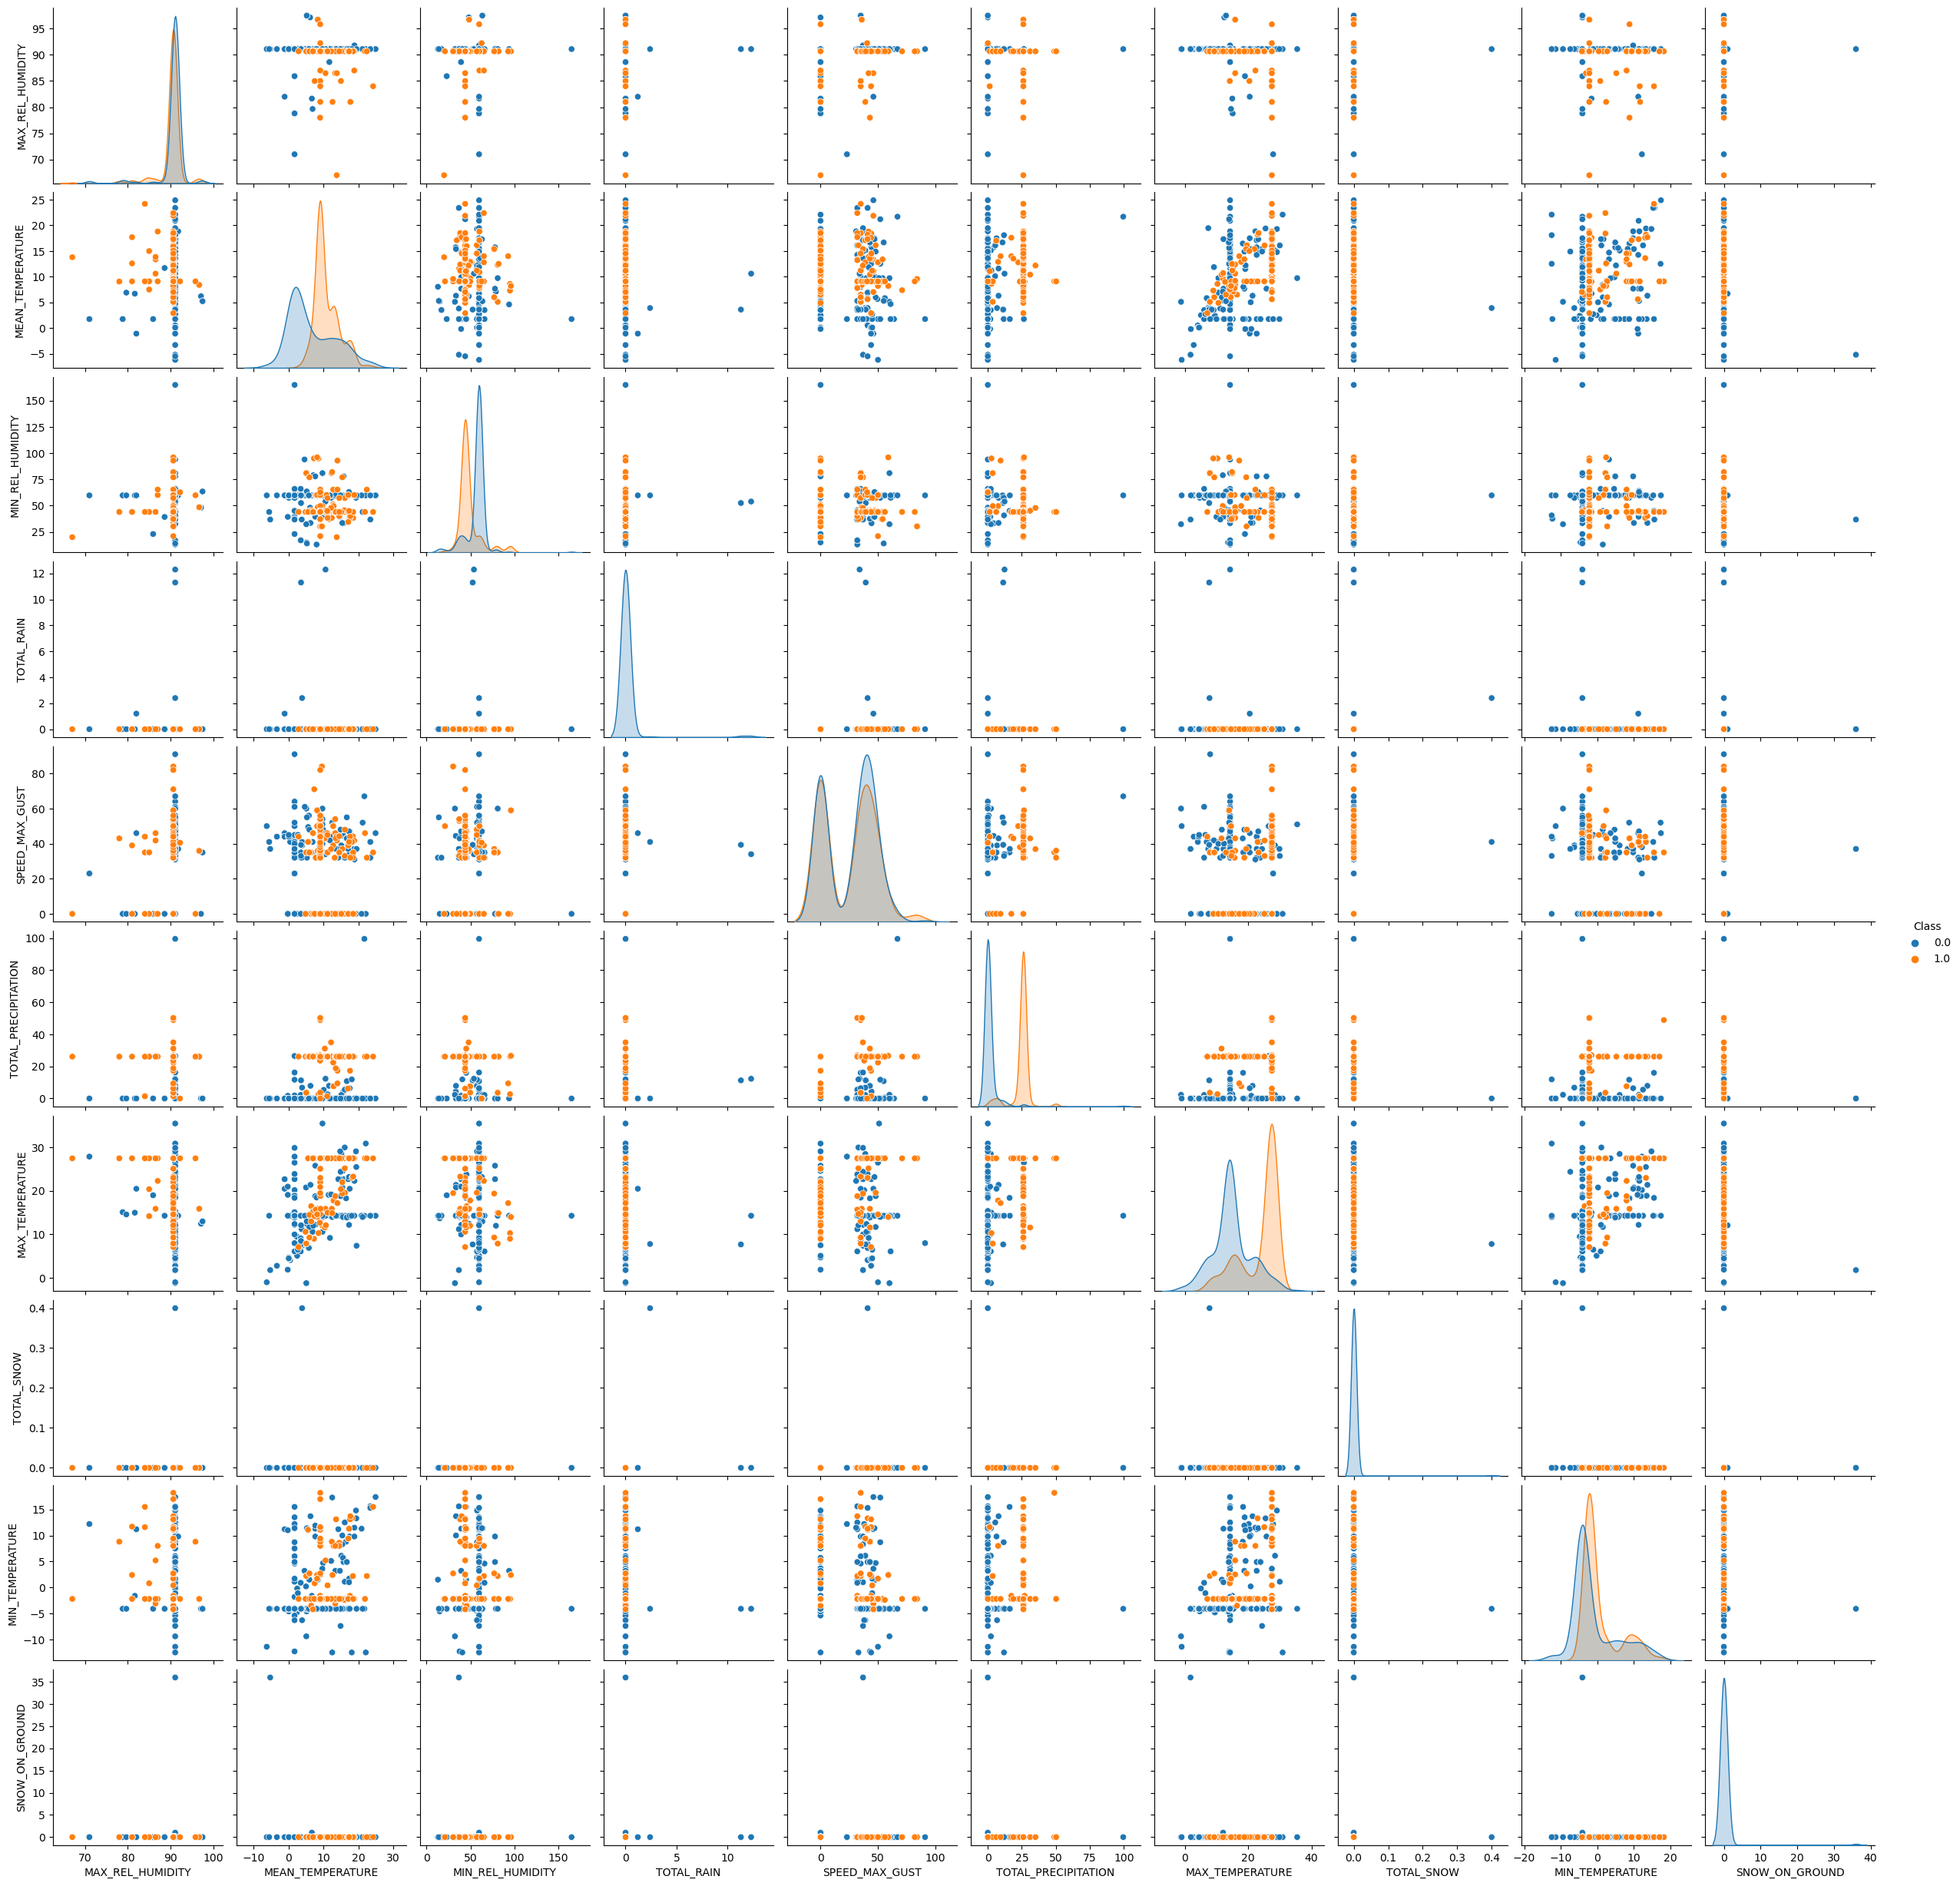

In [ ]:
# plotting the different features against each other
sb.pairplot(fire_df_clean, hue='Class')
plt.show()

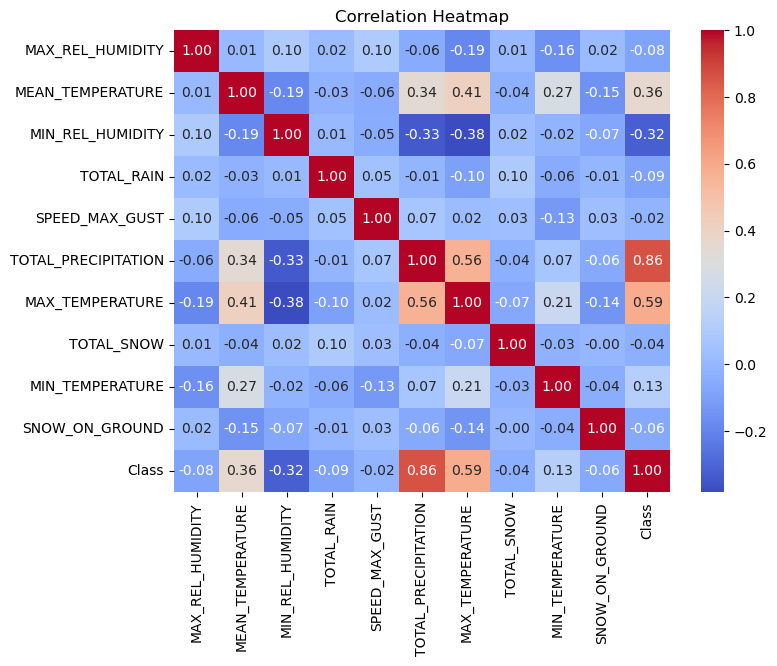

In [ ]:
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sb.heatmap(fire_df_clean.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')  # Set the title of the heatmap
plt.show()

It looks like there are three features which have the least correlation with class and the other features: total rain, total snow, and snow on ground.  

Notably we could expect that snow would not play a large factor in this data at all, as the data was build to contain weather data in roughly the same seasons as the observed fires, and the fires all occured between late spring and early fall, times when we would not expect to have any snow. With this both the plots and considerations of the data in mind, it will make sense to remove both snow features from the data set.

The total rain feature is more subtle.  In practice, we would expect that the presence of rain to impede fires, however this suggests that it is not a factor.  In the initial preparation of data, it was noted that there were many NaN values for total rain.  It could be that the weather stations used in this model did not record the amount of local rain.  One of the other features in the data is total precipitation.  The total precipitation feature contains far more nonzero data (meaning it also had less NaN data to begin with), and should contain within it the data of total rain (as we expect there to be minimal snow in the months with fires).  For this reason, we will also drop the total rain feature.


In [ ]:
# checking the value counts for total snow, snow on ground features, and total rain
display(fire_df_clean['TOTAL_SNOW'].value_counts(),
        fire_df_clean['SNOW_ON_GROUND'].value_counts(),
        fire_df_clean['TOTAL_RAIN'].value_counts())

0.0    527
0.4      1
Name: TOTAL_SNOW, dtype: int64

0.0     523
1.0       3
36.0      2
Name: SNOW_ON_GROUND, dtype: int64

0.0     522
11.3      2
12.3      2
1.2       1
2.4       1
Name: TOTAL_RAIN, dtype: int64

In [ ]:
# removing the snow and rain features
fire_df = fire_df_clean.drop(columns = ['TOTAL_SNOW', 'SNOW_ON_GROUND', 'TOTAL_RAIN'])

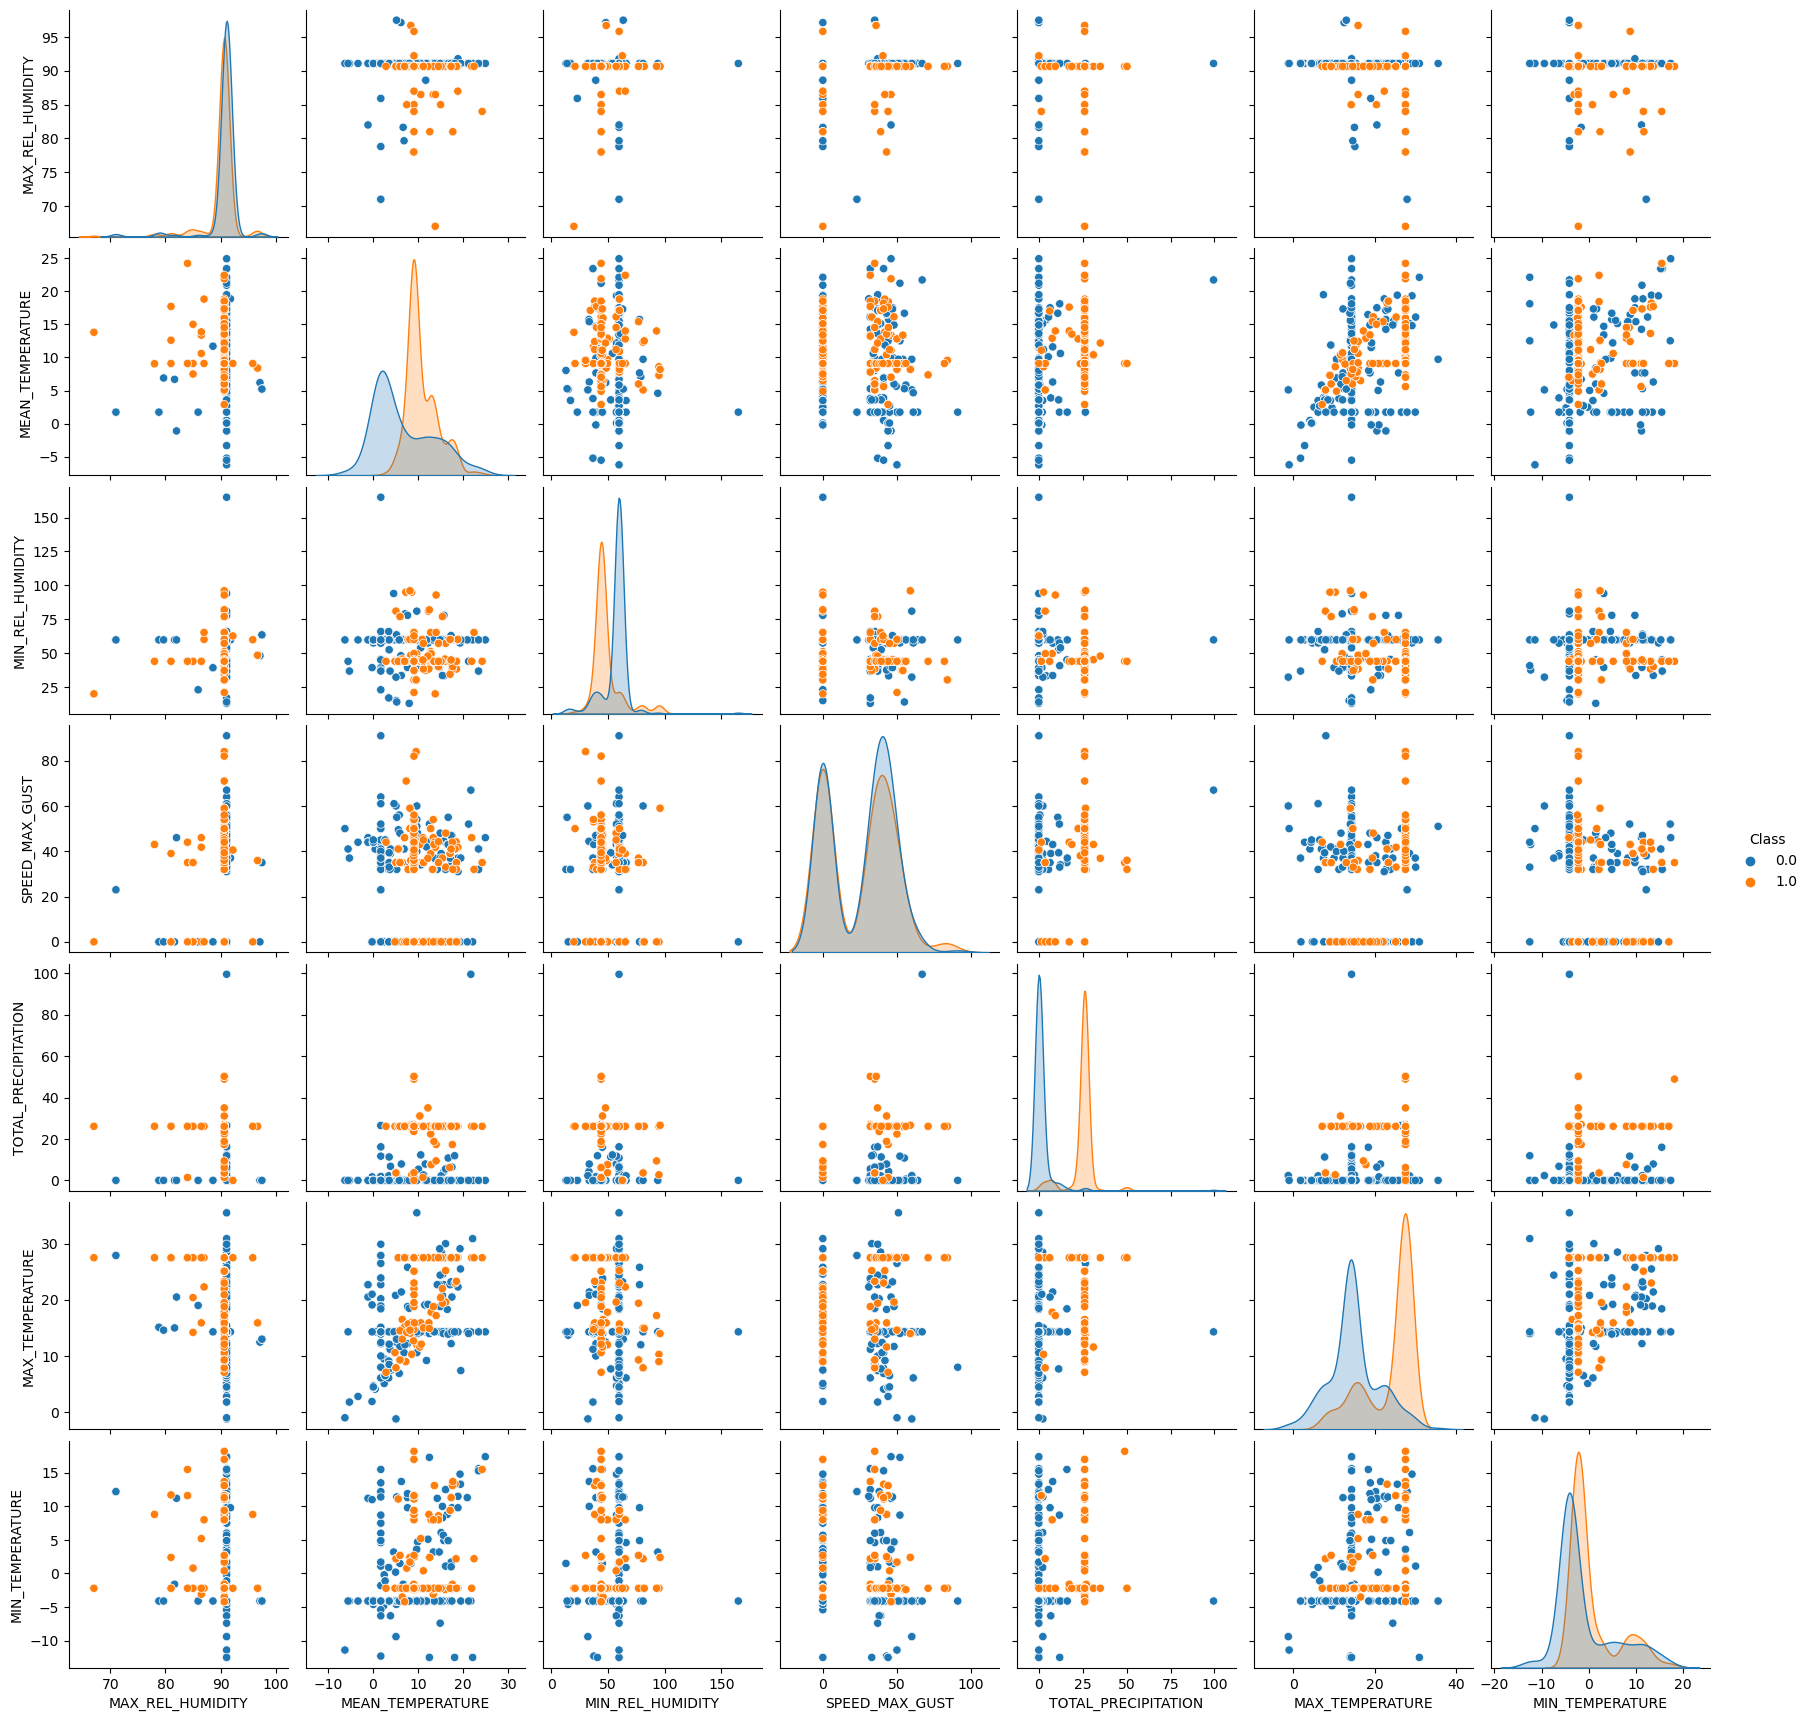

In [ ]:
# plotting the different features of the updated data set
sb.pairplot(fire_df, hue='Class')
plt.show()

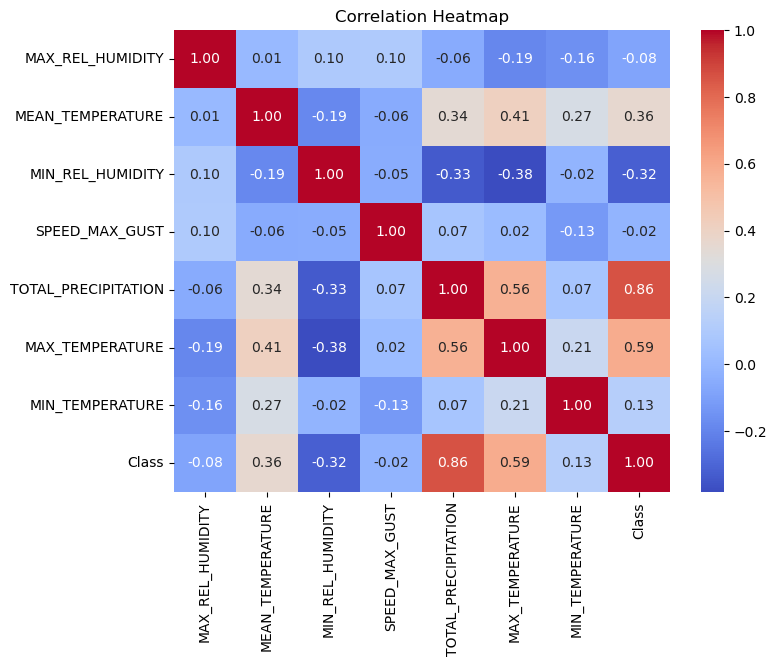

In [ ]:
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sb.heatmap(fire_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')  # Set the title of the heatmap
plt.show()

____________

_____________

<a id="modeling"></a>

# Modeling

[[ go back to the top ]](#toc)

An exploration of recent literature on the topic of wildfire occurences suggests that it is not necessarily evident a priori which classificaiton model would be best to use for our data set.  We will consider all of the basic classification models, perform a simple test to see if the model seems viable (using a single-train test), and proceed with a cross validation and hyperparameter tuning if the preliminary test suggests that the model has potential.

________________

Splitting up the data into test and train data for model requiring non-standardized data.

In [ ]:
# Splitting into features and target variable
X = fire_df.iloc[:, :-1]  # Features (all columns except the last)
y = fire_df.iloc[:, -1]   # Target variable (last column)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=10)

_____________

<a id="decision_tree"></a>
## Decision tree model

[[ go back to the top ]](#toc)

We start with the decision tree model.  We perform our simple test (which has an interesting result), and proceed with some tuning of the model.

In [ ]:
# Creating and training the Decision Tree model to see if this model could be reasonable to use
tree_model = DecisionTreeClassifier(random_state=36)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=36)

In [ ]:
# Predicting on the train set
y_pred_tree_train = tree_model.predict(X_train)
# Evaluating the model on the train set
accuracy_train = accuracy_score(y_train, y_pred_tree_train)
precision_train = precision_score(y_train, y_pred_tree_train)
recall_train = recall_score(y_train, y_pred_tree_train)
f1_train = f1_score(y_train, y_pred_tree_train)
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"f1: {f1_train}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1: 1.0


In [ ]:
# Predicting on the test set
y_pred_tree = tree_model.predict(X_test)
# Evaluating the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_tree)
precision_test = precision_score(y_test, y_pred_tree)
recall_test = recall_score(y_test, y_pred_tree)
f1_test = f1_score(y_test, y_pred_tree)
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"f1: {f1_test}")

Accuracy: 0.9905660377358491
Precision: 0.9821428571428571
Recall: 1.0
f1: 0.9909909909909909


The results of the simple test were positive.  We will perform cross-validation on this model to get a better gauge of the accuracy on our data set.

In [ ]:
# Performing 5-fold cross-validation
tree_scores = cross_val_score(tree_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", tree_scores, '\n')
print("Mean accuracy:", tree_scores.mean())

Cross-validation scores: [1.         0.98823529 0.97619048 0.98809524 1.        ] 

Mean accuracy: 0.9905042016806723


We proceed with a simple hyperparameter tuning of the decision tree model, and test the tuned model using the test set.

In [ ]:
# Defining hyperparameters to tune
tree_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Performing Grid Search with cross-validation
tree_grid_search = GridSearchCV(estimator=tree_model, param_grid=tree_param_grid, cv=5)
tree_grid_search.fit(X_train, y_train)

# Best hyperparameters found
tree_best_params = tree_grid_search.best_params_
print("Best hyperparameters:", tree_best_params, '\n')

# Evaluate the model with best hyperparameters on test set
tree_best_model = tree_grid_search.best_estimator_
tree_accuracy = tree_best_model.score(X_test, y_test)
print(f"Accuracy on test set with best hyperparameters: {tree_accuracy}")

Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2} 

Accuracy on test set with best hyperparameters: 0.9905660377358491


We can view the tuned decision tree to understand what the model is actual doing.

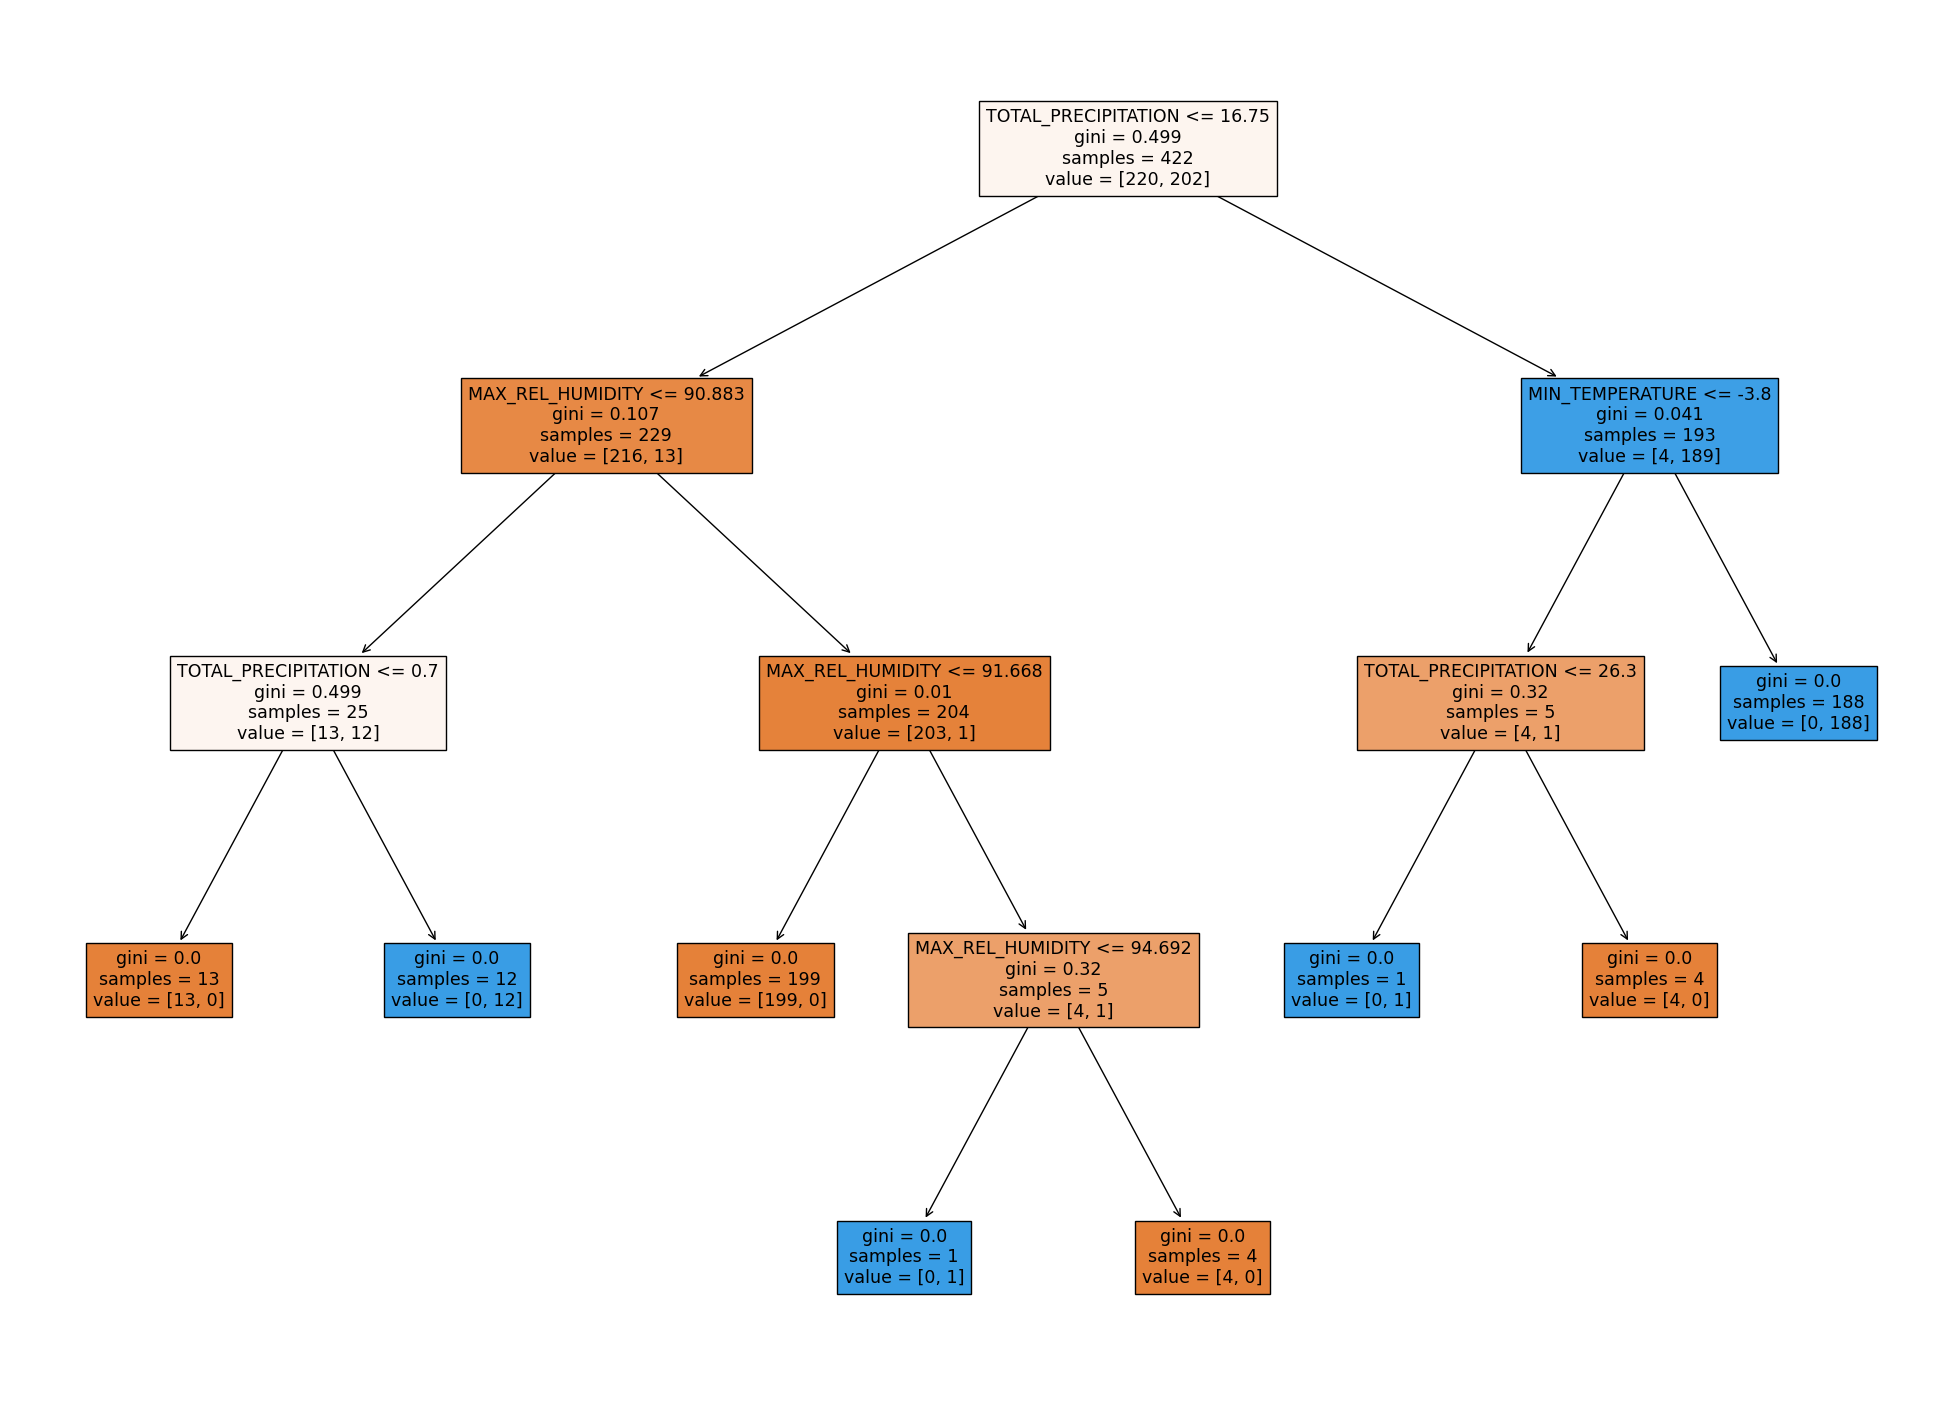

In [ ]:
# plotting the optimal decision tree
plt.figure(figsize = (25,18))
tree.plot_tree(tree_best_model,feature_names=fire_df.columns, filled = True)
plt.show()

### Post pruning.

In [ ]:
path = tree_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00235805 0.00379147 0.01477298 0.02669884 0.42241208]


In [ ]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

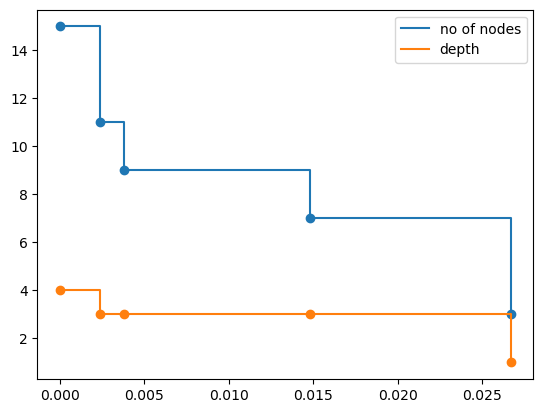

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

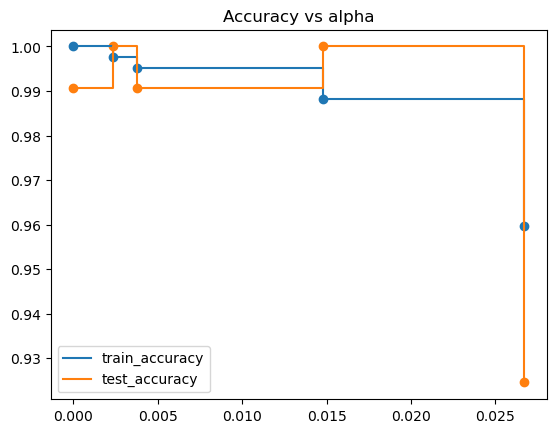

In [ ]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [ ]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.06)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')


Train score 0.9597156398104265
Test score 0.9245283018867925


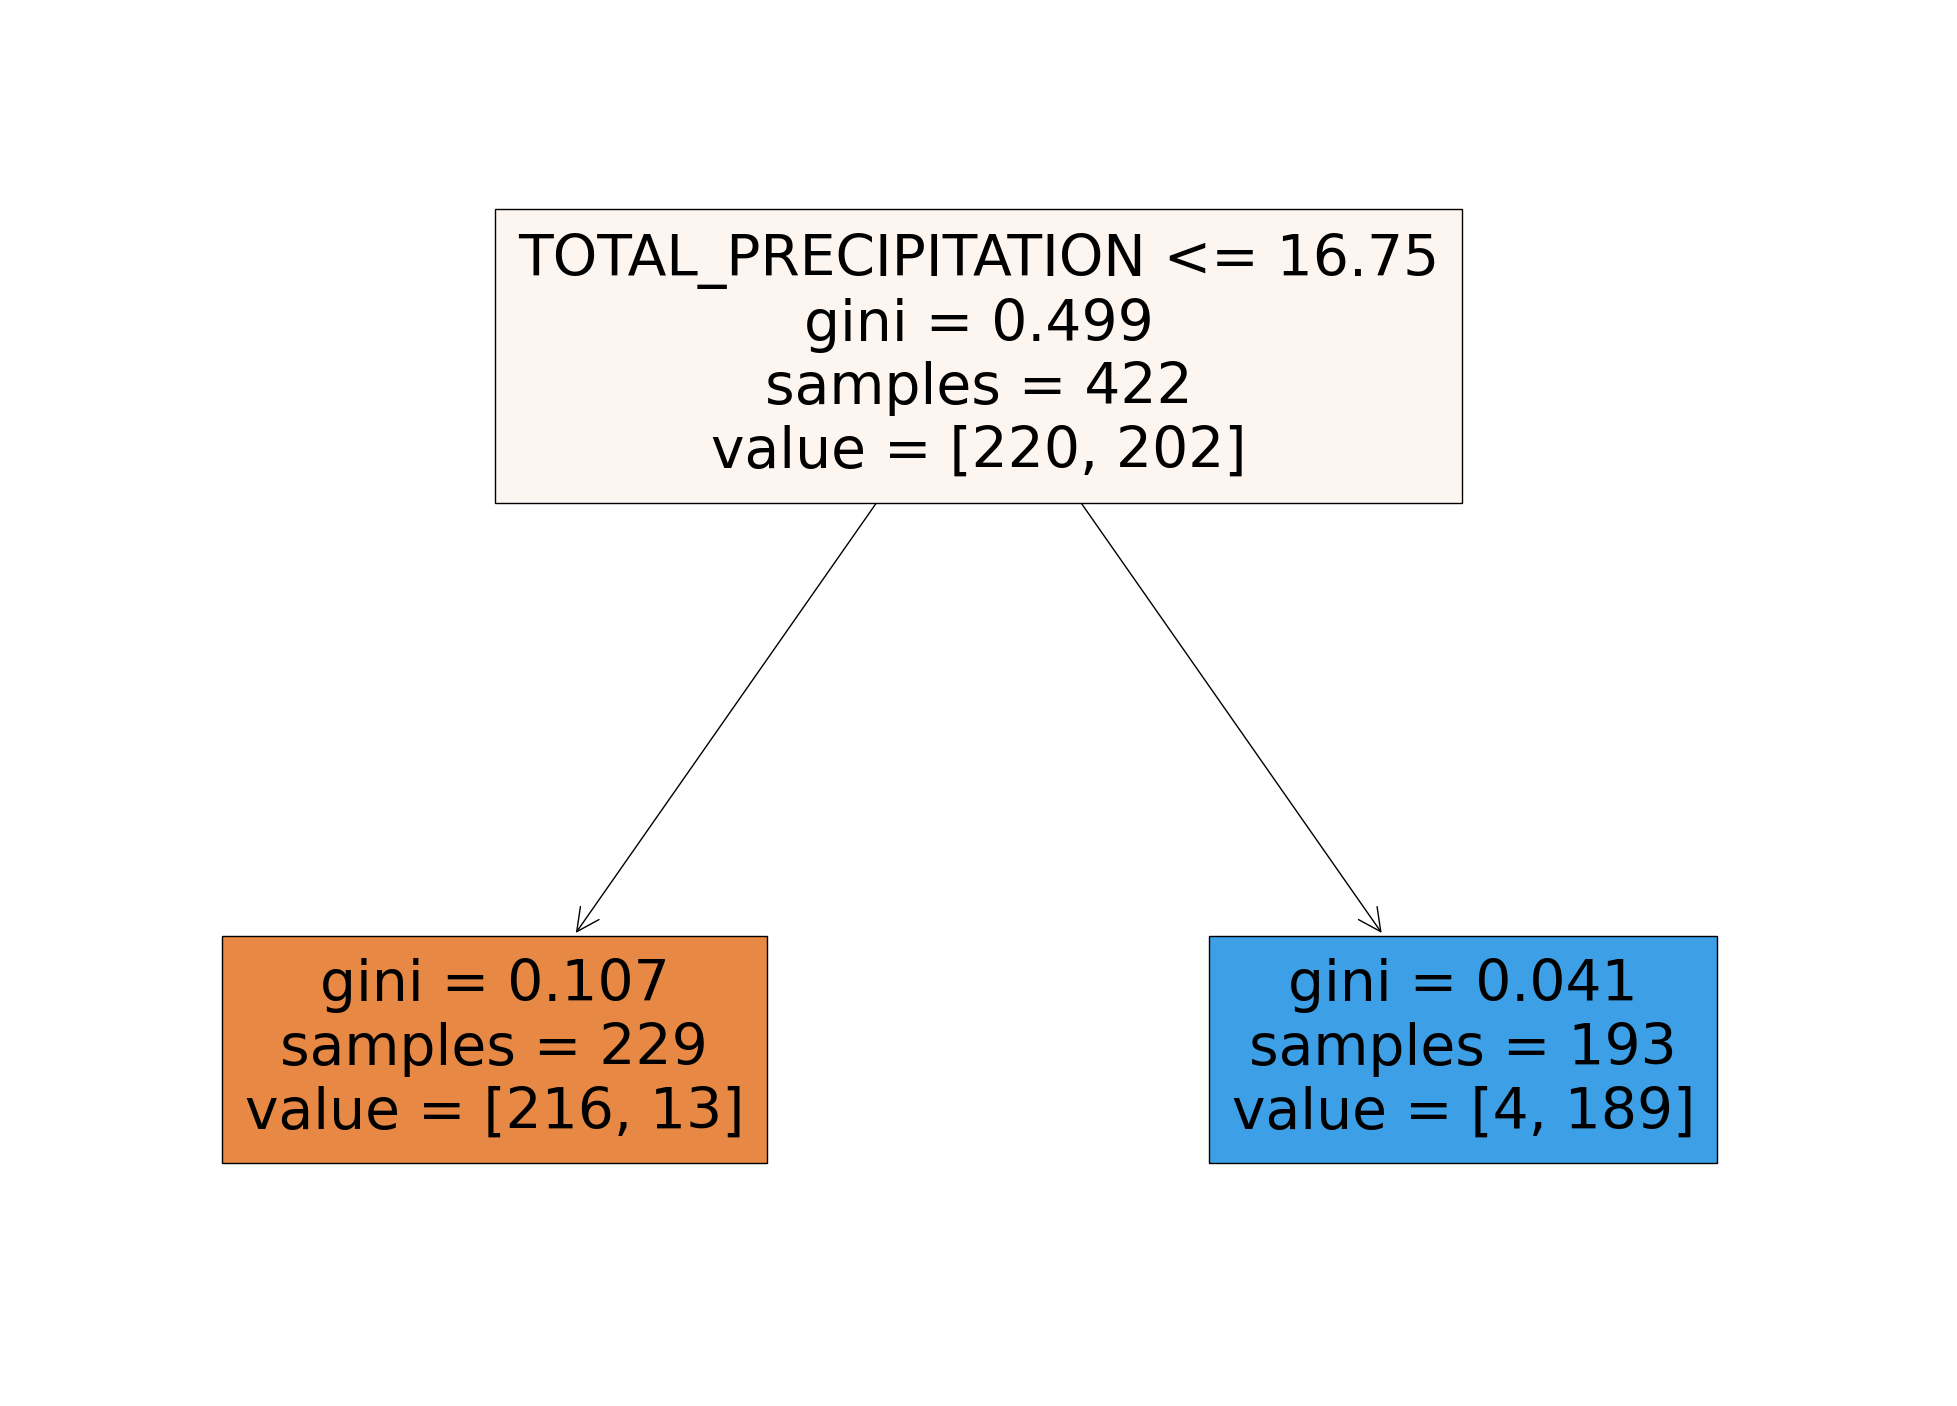

In [ ]:
# plotting the optimal decision tree
plt.figure(figsize = (25,18))
tree.plot_tree(clf_,feature_names=fire_df.columns, filled = True)
plt.show()

______________________

<a id="random_forest"></a>
## Random forest model

[[ go back to the top ]](#toc)

Making and tuning randon forest model.

In [ ]:
# Creating and training the Random Forest model to see if this model could be reasonable to use
forest_model = RandomForestClassifier(n_estimators=100, random_state=18)
forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=18)

In [ ]:
# Predicting on the train set
y_pred_forest_train = forest_model.predict(X_train)
# Evaluating the model on the train set
accuracy_train = accuracy_score(y_train, y_pred_forest_train)
precision_train = precision_score(y_train, y_pred_forest_train)
recall_train = recall_score(y_train, y_pred_forest_train)
f1_train = f1_score(y_train, y_pred_forest_train)
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"f1: {f1_train}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1: 1.0


In [ ]:
# Predicting on the test set
y_pred_forest = forest_model.predict(X_test)
# Evaluating the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_forest)
precision_test = precision_score(y_test, y_pred_forest)
recall_test = recall_score(y_test, y_pred_forest)
f1_test = f1_score(y_test, y_pred_forest)
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"f1: {f1_test}")

Accuracy: 0.9622641509433962
Precision: 1.0
Recall: 0.9272727272727272
f1: 0.9622641509433962


The results of the simple test were positive.  We will perform cross-validation on this model to get a better gauge of the accuracy on our data set.

In [ ]:
# Performing 5-fold cross-validation
forest_scores = cross_val_score(forest_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", forest_scores, '\n')
print("Mean accuracy:", forest_scores.mean())

Cross-validation scores: [1.         1.         0.98809524 1.         1.        ] 

Mean accuracy: 0.9976190476190476


We proceed with a simple hyperparameter tuning of the random forest model, and test the tuned model using the test set.

In [ ]:
# Defining hyperparameters to tune
forest_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Performing Grid Search with cross-validation
forest_grid_search = GridSearchCV(estimator=forest_model, param_grid=forest_param_grid, cv=5)
forest_grid_search.fit(X_train, y_train)

# Best hyperparameters found
forest_best_params = forest_grid_search.best_params_
print("Best hyperparameters:", forest_best_params, '\n')

# Evaluate the model with best hyperparameters on test set
forest_best_model = forest_grid_search.best_estimator_
forest_accuracy = forest_best_model.score(X_test, y_test)
print(f"Accuracy on test set with best hyperparameters: {forest_accuracy}")

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} 

Accuracy on test set with best hyperparameters: 0.9622641509433962


_____________

<a id="gradient_boosting"></a>
## Gradient boosting model

[[ go back to the top ]](#toc)

Making and tuning a gradient boosting model.

In [ ]:
# Creating and training the Gradient Boosting model to see if this model could be reasonable to use
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
# Predicting on the train set
y_pred_gb_train = gb_model.predict(X_train)
# Evaluating the model on the train set
accuracy_train = accuracy_score(y_train, y_pred_gb_train)
precision_train = precision_score(y_train, y_pred_gb_train)
recall_train = recall_score(y_train, y_pred_gb_train)
f1_train = f1_score(y_train, y_pred_gb_train)
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"f1: {f1_train}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1: 1.0


In [ ]:
# Predicting on the test set
y_pred_gb = gb_model.predict(X_test)
# Evaluating the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_gb)
precision_test = precision_score(y_test, y_pred_gb)
recall_test = recall_score(y_test, y_pred_gb)
f1_test = f1_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"f1: {f1_test}")

Accuracy: 0.9905660377358491
Precision: 0.9821428571428571
Recall: 1.0
f1: 0.9909909909909909


The results of the simple test were positive.  We will perform cross-validation on this model to get a better gauge of the accuracy on our data set.

In [ ]:
# Performing 5-fold cross-validation
scores = cross_val_score(gb_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores, '\n')
print("Mean accuracy:", scores.mean())

Cross-validation scores: [1.         1.         0.98809524 1.         1.        ] 

Mean accuracy: 0.9976190476190476


We proceed with a simple hyperparameter tuning of the gradient boosting model, and test the tuned model using the test set.

In [ ]:
# Defining hyperparameters to tune
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Performing Grid Search with cross-validation
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=5)
gb_grid_search.fit(X_train, y_train)

# Best hyperparameters found
gb_best_params = gb_grid_search.best_params_
print("Best hyperparameters:", gb_best_params, '\n')

# Evaluate the model with best hyperparameters on test set
gb_best_model = gb_grid_search.best_estimator_
gb_accuracy = gb_best_model.score(X_test, y_test)
print(f"Accuracy on test set with best hyperparameters: {gb_accuracy}")

Best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100} 

Accuracy on test set with best hyperparameters: 0.9905660377358491


_________________

We now move away from the tree-based models, and look at models with standardized data.

Scaling the features and splitting up the data into test and train data.

In [ ]:
scaler = StandardScaler()

In [ ]:
# Splitting into features and target variable
X = fire_df.iloc[:, :-1]  # Features (all columns except the last)
y = fire_df.iloc[:, -1]   # Target variable (last column)

# Standardizing the data with StandardScaler
X_scaled = scaler.fit_transform(X)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=True, test_size=0.2, random_state=68)

__________________

<a id="log_regression"></a>
## Logistic Regression Model

[[ go back to the top ]](#toc)

Making and tuning logistic regression model.

In [ ]:
# Creating and training the logistic regression model to see if this model could be reasonable to use
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Predicting on the train set
y_pred_log_train = log_model.predict(X_train)
# Evaluating the model on the train set
accuracy_train = accuracy_score(y_train, y_pred_log_train)
print(f"Accuracy: {accuracy_train}")

Accuracy: 0.9715639810426541


In [ ]:
# Predicting on the test set
y_pred_log = log_model.predict(X_test)
# Evaluating the model on the test set
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9622641509433962


The results of the simple test were positive.  We will perform cross-validation on this model to get a better gauge of the accuracy on our data set.

In [ ]:
# Performing 5-fold cross-validation
scores = cross_val_score(log_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores, '\n')
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.97647059 0.94117647 0.94047619 0.97619048 0.97619048] 

Mean accuracy: 0.9621008403361344


We proceed with a simple hyperparameter tuning of the logistic regression model, and test the tuned model using the test set.

In [ ]:
#Note this freaks out and I don't know how to fix it

# Defining hyperparameters to tune
log_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']  # Solver algorithms
}

# Performing Grid Search with cross-validation
log_grid_search = GridSearchCV(estimator=log_model, param_grid=log_param_grid, cv=5, scoring='accuracy')
log_grid_search.fit(X_train, y_train)

# Best hyperparameters found
log_best_params = log_grid_search.best_params_
print("Best hyperparameters:", log_best_params, '\n')

# Evaluate the model with best hyperparameters on test set
log_best_model = log_grid_search.best_estimator_
log_accuracy = log_best_model.score(X_test, y_test)
print(f"Accuracy on test set with best hyperparameters: {log_accuracy}")

C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

Best hyperparameters: {'C': 10, 'solver': 'liblinear'} 

Accuracy on test set with best hyperparameters: 0.9622641509433962


______________

<a id="knn"></a>
## K-nearest neighbour Model

[[ go back to the top ]](#toc)

Making and tuning a KNN-model

In [ ]:
# Creating and training the K-Nearest Neighbors model to see if this model could be reasonable to use
k = 5  # Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# Predicting on the train set
y_pred_knn_train = knn_model.predict(X_train)
# Evaluating the model on the train set
accuracy_train = accuracy_score(y_train, y_pred_knn_train)
print(f"Accuracy: {accuracy_train}")

Accuracy: 0.981042654028436


C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [ ]:
# Predicting on the test set
y_pred_knn = knn_model.predict(X_test)
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9716981132075472


C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


The results of the simple test were positive.  We will perform cross-validation on this model to get a better gauge of the accuracy on our data set.

In [ ]:
# Performing 5-fold cross-validation
scores = cross_val_score(knn_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores, '\n')
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.98823529 0.97647059 0.97619048 0.95238095 0.95238095] 

Mean accuracy: 0.9691316526610645


C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

We proceed with a simple hyperparameter tuning of the k-nearest neighbour model, and test the tuned model using the test set.

In [ ]:
#Note this freaks out and I don't know how to fix it

# Define hyperparameters to tune
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Values of 'k' (number of neighbors)
    'weights': ['uniform', 'distance'],  # Weighting of neighbors
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Performing Grid Search with cross-validation
knn_grid_search = GridSearchCV(estimator=knn_model, param_grid=knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

# Best hyperparameters found
knn_best_params = knn_grid_search.best_params_
print("Best hyperparameters:", knn_best_params, '\n')

# Evaluate the model with best hyperparameters on test set
knn_best_model = knn_grid_search.best_estimator_
knn_accuracy = knn_best_model.score(X_test, y_test)
print(f"Accuracy on test set with best hyperparameters: {knn_accuracy}")

C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'} 

Accuracy on test set with best hyperparameters: 0.9905660377358491


C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\c-mah\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

_________________

<a id="svm"></a>
## SVM Model

[[ go back to the top ]](#toc)

In [ ]:
# Creating and training the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Linear kernel for demonstration purposes
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
# Predicting on the train set
y_pred_svm_train = svm_model.predict(X_train)
# Evaluating the model on the train set
accuracy_train = accuracy_score(y_train, y_pred_svm_train)
print(f"Accuracy: {accuracy_train}")

Accuracy: 0.9549763033175356


In [ ]:
# Predicting on the test set
y_pred_svm = svm_model.predict(X_test)
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9339622641509434


The results of the simple test were positive.  We will perform cross-validation on this model to get a better gauge of the accuracy on our data set.

In [ ]:
# Performing 5-fold cross-validation
scores = cross_val_score(svm_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores, '\n')
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.95294118 0.92941176 0.92857143 0.97619048 0.97619048] 

Mean accuracy: 0.9526610644257703


We proceed with a simple hyperparameter tuning of the random forest model, and test the tuned model using the test set.

In [ ]:
# Define hyperparameters to tune
svm_param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient (for 'rbf' and 'poly')
}

# Performing Grid Search with cross-validation
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)

# Best hyperparameters found
svm_best_params = svm_grid_search.best_params_
print("Best hyperparameters:", svm_best_params, '\n')

# Evaluate the model with best hyperparameters on test set
svm_best_model = svm_grid_search.best_estimator_
svm_accuracy = svm_best_model.score(X_test, y_test)
print(f"Accuracy on test set with best hyperparameters: {svm_accuracy}")

Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} 

Accuracy on test set with best hyperparameters: 0.9811320754716981


___________________

<a id="nb"></a>
## Naive Bayes Model

[[ go back to the top ]](#toc)

Making a naive bayes model.

In [ ]:
# Creating and training the Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Predicting on the train set
y_pred_nb_train = nb_model.predict(X_train)
# Evaluating the model on the train set
accuracy_train = accuracy_score(y_train, y_pred_nb_train)
print(f"Accuracy: {accuracy_train}")

Accuracy: 0.9502369668246445


In [ ]:
# Predicting on the test set
y_pred_nb = nb_model.predict(X_test)
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9245283018867925


The results of the simple test were positive.  We will perform cross-validation on this model to get a better gauge of the accuracy on our data set.

In [ ]:
# Performing 5-fold cross-validation
scores = cross_val_score(svm_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores, '\n')
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.95294118 0.92941176 0.92857143 0.97619048 0.97619048] 

Mean accuracy: 0.9526610644257703


We proceed with a simple hyperparameter tuning of the random forest model, and test the tuned model using the test set.

In [ ]:
# Defining hyperparameters to tune (if any)
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]  # Example parameter to tune (var_smoothing)
}

# Performing Grid Search with cross-validation
nb_grid_search = GridSearchCV(estimator=nb_model, param_grid=nb_param_grid, cv=5)
nb_grid_search.fit(X_train, y_train)

# Best hyperparameters found
nb_best_params = nb_grid_search.best_params_
print("Best hyperparameters:", nb_best_params)

# Evaluate the model with best hyperparameters on test set
nb_best_model = nb_grid_search.best_estimator_
nb_accuracy = nb_best_model.score(X_test, y_test)
print(f"Accuracy on test set with best hyperparameters: {accuracy}")

Best hyperparameters: {'var_smoothing': 1e-09}
Accuracy on test set with best hyperparameters: 0.9245283018867925


___________

___________________

<a id="conclusions"></a>
# Conclusions

[[ go back to the top ]](#toc)

All of the models scored very well on our data set (accuracy > 0.92 for all models).

We take the opporunity to look at limitations of our data set and how the models weighed features.

____________

<a id="data_limitations"></a>
## Data Limitations

[[ go back to the top ]](#toc)

The main limiting factor in the strength of the models is that data itself.  In principle the goal of our models is to make a prediction using two very non-linear meta-features: recent atmospheric conditions, and the occurence of a lightning storm.  The former being a somewhat of a measure of how combustible an area is (e.g. an area that has been rained on for many days in a row would be less likely to ignite or spread a fire than an area with no rain), and the latter being a measure of when combustion will occur (i.e. we expect rain to accpomany the lightning).  

A complication with trying to build the model around these meta-features is that neither one is a feature that is measured.  The relevant data that we could obtain was weather data, by which atmospheric conditions would be built out of several days of data (e.g. considering a weeks worth of weather conditions), and the presence of a thunderstorms utilizes the weather data of a single day (i.e. does the data suggest a storm).  In practice, we made a decision to consider focus mainly on recent atmospheric conditions, by aggregating our weather day over a span of days.  A more robust data set would perhaps consider collections of individual days rather than a single aggregate.  This should make the importance on "recent" more clear (i.e. how many days back are useful), and give single-day data with which to determine thunderstorms.

______________

<a id="feature_importance"></a>
## Feature Importance

[[ go back to the top ]](#toc)

We can take the opportunity to investigate how various models weighed the different features, especially as compared to the correlations among the features themselves.  This will give both an insight into the models themselves, and the allow us to make sense of how the models value them as compared to what we would expect.  For the models not represented below, it would be possible to cycle through subset of the features to gauge some level of importance, however that does not necessarily lead the kinds of insights we want to draw, and due to the small number of features in general, would potentially lead to misinformation caused classification with too few features.

In [ ]:
# decision tree model feature imporantances
# Access feature importances
tree_feature_importances = tree_best_model.feature_importances_

# Create a DataFrame to display feature in order of importance
tree_feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                           'Importance': tree_feature_importances}).sort_values(by='Importance', ascending=False)
print('Feature Importance from the Decision Tree Model', '\n', tree_feature_importance_df)


# random forest model feature importances
# Access feature importances
forest_feature_importances = forest_best_model.feature_importances_

# Create a DataFrame to display feature importances
forest_feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                             'Importance': forest_feature_importances}).sort_values(by='Importance', ascending=False)
print('\n\n', 'Feature Importance from the Random Forest Model', '\n',forest_feature_importance_df)


# gradient boosting model feature importances
# Access feature importances
gb_feature_importances = gb_model.feature_importances_

# Create a DataFrame to display feature importances
gb_feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                         'Importance': gb_feature_importances}).sort_values(by='Importance', ascending=False)
print('\n\n', 'Feature Importance from the Gradient Boosting Model', '\n', gb_feature_importance_df)


# log regression model feature importances
# Access the coefficients (feature importances)
coefficients = log_best_model.coef_[0]

# Mapping feature names to their coefficients
feature_importance = dict(zip(fire_df.columns, coefficients))

# Display feature importance
print('\n\n', 'Feature Importance from the Logistic Regression Model', '\n', "Feature Importance (Coefficients):")
for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

Feature Importance from the Decision Tree Model 
                Feature  Importance
4  TOTAL_PRECIPITATION    0.913215
0     MAX_REL_HUMIDITY    0.057185
6      MIN_TEMPERATURE    0.029600
1     MEAN_TEMPERATURE    0.000000
2     MIN_REL_HUMIDITY    0.000000
3       SPEED_MAX_GUST    0.000000
5      MAX_TEMPERATURE    0.000000


 Feature Importance from the Random Forest Model 
                Feature  Importance
4  TOTAL_PRECIPITATION    0.388423
0     MAX_REL_HUMIDITY    0.333690
6      MIN_TEMPERATURE    0.089818
5      MAX_TEMPERATURE    0.078998
2     MIN_REL_HUMIDITY    0.058029
1     MEAN_TEMPERATURE    0.047533
3       SPEED_MAX_GUST    0.003509


 Feature Importance from the Gradient Boosting Model 
                Feature  Importance
4  TOTAL_PRECIPITATION    0.904993
0     MAX_REL_HUMIDITY    0.058354
6      MIN_TEMPERATURE    0.030315
3       SPEED_MAX_GUST    0.002575
5      MAX_TEMPERATURE    0.001992
2     MIN_REL_HUMIDITY    0.001733
1     MEAN_TEMPERATURE    0.000038


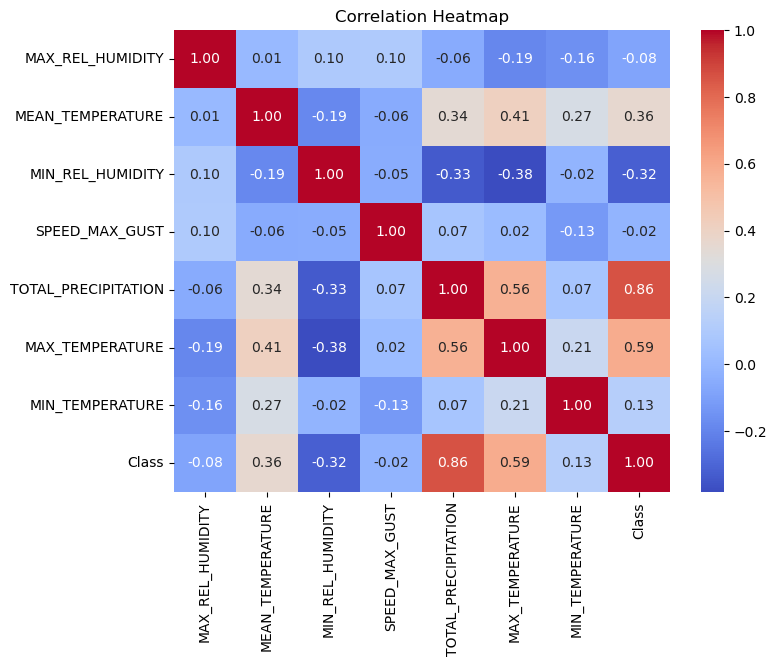

In [ ]:
# Assuming df is your dataframe
# You might need to clean or prepare your data before plotting

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sb.heatmap(fire_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')  # Set the title of the heatmap
plt.show()


There are several conclusions that we can draw from this information, regarding both the features and the models.

All of the above models rank total precipiation as most important, and notably having a positiv correlation with class 1 (fire).  This aligns with the correlations between class and the other features (as seen in the heat map), but is a interesting result given how the data was created.  From the setting of the problem, this aligns with what we would expect, as we expect lightning (the cause of the fire) to be accompanied by some form of precipitation, however we built our data set to be aggregated data (i.e. recent atmospheric data).  Built this way, we might expect that the correlation would be negative, as precepitation would suggest the conditions leading up to the fire were wet.  This might suggest that precipation on a given day is far more correlated to a fire than recent precipitation is to a non-fire.  This kind of idea could be addressed more clearly in the "more robust data set" mentioned above.

All three tree models weighed the features in a similar order, with total precipiation, relative humidity and minimum temperature being the top three.  This also showcases some of the failings of the decision tree model.  While it did perform very well and would be faster than the other tree models given a larger data set, the tuned decision tree model only considers 3 of the features.